In [1]:
print("test")

test


In [2]:
import pandas as pd
from LabData.DataLoaders.GutMBLoader import GutMBLoader
from LabData.DataLoaders.SubjectLoader import SubjectLoader
from LabData.DataLoaders.DietLoggingLoader import DietLoggingLoader
from LabData.DataLoaders.LifeStyleLoader import LifeStyleLoader
from LabData.DataLoaders.BodyMeasuresLoader import BodyMeasuresLoader
from LabData.DataLoaders.CuratedPhenotypeLoader import CuratedPhenotypeLoader
from LabData.DataLoaders.MedicalConditionLoader import MedicalConditionLoader
from LabData.DataAnalyses.TenK_Trajectories.utils import get_diet_logging_around_stage
import numpy as np

import pickle

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, confusion_matrix

/usr/wisdom/python3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/wisdom/python3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/wisdom/python3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/wisdom/python3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [3]:
stage = 'baseline' # 'baseline' or '02_00_visit'
species = 'segal_species' # 'segal_species' or 'mpa_species'

In [4]:
path = '/net/mraid20/export/genie/LabData/Analyses/tomerse/diet_mb/data/'

In [5]:
def explore_columns(df):
    for column in df.columns:
        print(column)
        print(df[column].value_counts())

## study_ids = [10, 1001, 1002]
study_ids = [10]
subjects_dl = SubjectLoader()
subjects_data = subjects_dl.get_data(groupby_reg='first', study_ids=study_ids)
subjects_df = subjects_data.df
print(subjects_df)

                                             StudyTypeID  ...              tz
RegistrationCode Date                                     ...                
10K_1000028368   2020-03-22 08:26:05.077073         10.0  ...  Asia/Jerusalem
10K_1000273395   2020-03-05 20:53:54.399388         10.0  ...  Asia/Jerusalem
10K_1000633050   2021-06-21 14:23:50.372010         10.0  ...  Asia/Jerusalem
10K_1000942861   2021-06-11 11:30:37.386358         10.0  ...  Asia/Jerusalem
10K_1001106466   2024-12-15 15:42:22.632981         10.0  ...  Asia/Jerusalem
...                                                  ...  ...             ...
10K_9999226141   2019-12-04 07:07:07.815688         10.0  ...  Asia/Jerusalem
10K_9999409119   2020-02-22 15:19:08.365584         10.0  ...  Asia/Jerusalem
10K_9999623844   2023-02-19 01:46:16.838996         10.0  ...  Asia/Jerusalem
10K_9999732920   2022-12-23 22:20:48.083986         10.0  ...  Asia/Jerusalem
10K_9999767769   2020-01-31 09:11:04.104338         10.0  ...  A

### Load Microbiome Data

In [6]:
gut_bacteria_df = pd.read_pickle(path + f"gut_bacteria_df_{stage}.pkl")
gut_bacteria_df

,s__Acidaminococcus_intestini,s__Adlercreutzia_equolifaciens,s__Agathobaculum_butyriciproducens,s__Akkermansia_muciniphila,s__Alistipes_SGB2313,s__Alistipes_communis,s__Alistipes_dispar,s__Alistipes_finegoldii,s__Alistipes_ihumii,s__Alistipes_indistinctus,s__Alistipes_onderdonkii,s__Alistipes_provencensis,s__Alistipes_putredinis,s__Alistipes_senegalensis,s__Alistipes_shahii,s__Alistipes_sp_AF17_16,s__Alistipes_timonensis,s__Anaerobutyricum_hallii,s__Anaerobutyricum_soehngenii,s__Anaeromassilibacillus_senegalensis,s__Anaerostipes_hadrus,s__Anaerotignum_faecicola,s__Anaerotignum_sp_MSJ_24,s__Anaerotruncus_colihominis,s__Bacteroides_caccae,s__Bacteroides_cellulosilyticus,s__Bacteroides_clarus,s__Bacteroides_eggerthii,s__Bacteroides_faecis,s__Bacteroides_finegoldii,s__Bacteroides_fragilis,s__Bacteroides_intestinalis,s__Bacteroides_nordii,s__Bacteroides_ovatus,s__Bacteroides_pectinophilus,s__Bacteroides_salyersiae,s__Bacteroides_stercoris,s__Bacteroides_thetaiotaomicron,s__Bacteroides_uniformis,s__Bacteroides_xylanisolvens,...,s__Roseburia_sp_AF02_12,s__Roseburia_sp_AM59_24XD,s__Roseburia_sp_BX1005,s__Ruminococcus_SGB4421,s__Ruminococcus_bicirculans,s__Ruminococcus_bovis,s__Ruminococcus_bromii,s__Ruminococcus_callidus,s__Ruminococcus_champanellensis,s__Ruminococcus_gnavus,s__Ruminococcus_lactaris,s__Ruminococcus_sp_AF41_9,s__Ruminococcus_torques,s__Ruthenibacterium_lactatiformans,s__Segatella_brunsvicensis,s__Segatella_copri,s__Segatella_hominis,s__Segatella_sinensis,s__Senegalimassilia_anaerobia,s__Simiaoa_sunii,s__Slackia_isoflavoniconvertens,s__Streptococcus_parasanguinis,s__Streptococcus_salivarius,s__Streptococcus_thermophilus,s__Sutterella_SGB9281,s__Sutterella_SGB9298,s__Sutterella_seckii,s__Sutterella_sp_AM11_39,s__Sutterella_wadsworthensis,s__Vescimonas_SGB15087,s__Vescimonas_coprocola,s__Vescimonas_fastidiosa,s__Victivallis_lenta,s__Victivallis_vadensis,s__Wujia_chipingensis,s__bacterium_210917_DFI_7_65,Richness,Shannon_diversity,modified_HACK_top17_score,GMWI2_score
RegistrationCode,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
10K_6313380878,-4.000000,-4.0,-1.954287,-2.607500,-4.0,-1.908530,-3.142613,-2.443643,-2.811620,-1.841583,-1.663428,-4.000000,-1.966522,-2.783591,-1.680215,-2.510590,-4.0,-2.873768,-4.000000,-4.0,-2.686681,-3.510590,-3.385651,-4.0,-2.385651,-2.757262,-2.841583,-3.142613,-4.000000,-4.000000,-2.469197,-3.686681,-4.000000,-2.297515,-4.000000,-2.482561,-4.000000,-2.873768,-1.618495,-4.000000,...,-4.000000,-4.000000,-4.000000,-4.000000,-1.747162,-4.0,-1.732438,-2.482561,-4.000000,-4.0,-3.142613,-2.987711,-3.288741,-4.000000,-4.0,-2.231836,-4.000000,-4.000000,-2.811620,-4.000000,-2.841583,-4.000000,-4.000000,-4.000000,-4.0,-4.000000,-4.000000,-4.000000,-1.908530,-4.000000,-4.000000,-4.000000,-3.385651,-4.000000,-2.364462,-4.0,194,4.35,402.93750,1.122120
10K_7612768952,-4.000000,-4.0,-2.802637,-1.899547,-4.0,-2.044230,-3.200577,-4.000000,-4.000000,-4.000000,-2.473578,-2.978728,-1.723456,-4.000000,-2.133630,-4.000000,-4.0,-3.279758,-4.000000,-4.0,-2.723456,-4.000000,-4.000000,-4.0,-2.473578,-1.835713,-4.000000,-4.000000,-4.000000,-4.000000,-4.000000,-3.376668,-3.677698,-2.636305,-4.000000,-4.000000,-2.487366,-2.802637,-2.460214,-4.000000,...,-3.677698,-4.000000,-4.000000,-4.000000,-1.548976,-4.0,-1.602151,-3.677698,-4.000000,-4.0,-2.802637,-4.000000,-4.000000,-3.677698,-4.0,-1.051871,-4.000000,-4.000000,-3.501607,-3.677698,-4.000000,-4.000000,-4.000000,-4.000000,-4.0,-4.000000,-4.000000,-2.656509,-4.000000,-2.271158,-4.000000,-2.487366,-4.000000,-3.677698,-3.075638,-4.0,194,4.25,406.75000,1.093215
10K_5604798077,-4.000000,-4.0,-2.398644,-2.820717,-4.0,-2.736397,-4.000000,-2.887664,-3.121747,-4.000000,-3.267875,-4.000000,-1.421538,-2.435367,-2.762725,-2.925453,-4.0,-4.000000,-4.000000,-4.0,-3.489724,-2.504447,-4.000000,-4.0,-2.925453,-3.489724,-4.000000,-4.000000,-4.000000,-4.000000,-4.000000,-4.000000,-4.000000,-2.364785,-2.551872,-4.000000,-4.000000,-2.966845,-1.906148,-

In [7]:
gut_bacteria_df = gut_bacteria_df.join(subjects_df[["age", "gender"]])
gut_bacteria_df = gut_bacteria_df.reset_index(level=[1], drop=True)
gut_bacteria_df = gut_bacteria_df.dropna()
gut_bacteria_df

,s__Acidaminococcus_intestini,s__Adlercreutzia_equolifaciens,s__Agathobaculum_butyriciproducens,s__Akkermansia_muciniphila,s__Alistipes_SGB2313,s__Alistipes_communis,s__Alistipes_dispar,s__Alistipes_finegoldii,s__Alistipes_ihumii,s__Alistipes_indistinctus,s__Alistipes_onderdonkii,s__Alistipes_provencensis,s__Alistipes_putredinis,s__Alistipes_senegalensis,s__Alistipes_shahii,s__Alistipes_sp_AF17_16,s__Alistipes_timonensis,s__Anaerobutyricum_hallii,s__Anaerobutyricum_soehngenii,s__Anaeromassilibacillus_senegalensis,s__Anaerostipes_hadrus,s__Anaerotignum_faecicola,s__Anaerotignum_sp_MSJ_24,s__Anaerotruncus_colihominis,s__Bacteroides_caccae,s__Bacteroides_cellulosilyticus,s__Bacteroides_clarus,s__Bacteroides_eggerthii,s__Bacteroides_faecis,s__Bacteroides_finegoldii,s__Bacteroides_fragilis,s__Bacteroides_intestinalis,s__Bacteroides_nordii,s__Bacteroides_ovatus,s__Bacteroides_pectinophilus,s__Bacteroides_salyersiae,s__Bacteroides_stercoris,s__Bacteroides_thetaiotaomicron,s__Bacteroides_uniformis,s__Bacteroides_xylanisolvens,...,s__Roseburia_sp_BX1005,s__Ruminococcus_SGB4421,s__Ruminococcus_bicirculans,s__Ruminococcus_bovis,s__Ruminococcus_bromii,s__Ruminococcus_callidus,s__Ruminococcus_champanellensis,s__Ruminococcus_gnavus,s__Ruminococcus_lactaris,s__Ruminococcus_sp_AF41_9,s__Ruminococcus_torques,s__Ruthenibacterium_lactatiformans,s__Segatella_brunsvicensis,s__Segatella_copri,s__Segatella_hominis,s__Segatella_sinensis,s__Senegalimassilia_anaerobia,s__Simiaoa_sunii,s__Slackia_isoflavoniconvertens,s__Streptococcus_parasanguinis,s__Streptococcus_salivarius,s__Streptococcus_thermophilus,s__Sutterella_SGB9281,s__Sutterella_SGB9298,s__Sutterella_seckii,s__Sutterella_sp_AM11_39,s__Sutterella_wadsworthensis,s__Vescimonas_SGB15087,s__Vescimonas_coprocola,s__Vescimonas_fastidiosa,s__Victivallis_lenta,s__Victivallis_vadensis,s__Wujia_chipingensis,s__bacterium_210917_DFI_7_65,Richness,Shannon_diversity,modified_HACK_top17_score,GMWI2_score,age,gender
RegistrationCode,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
10K_1000942861,-4.000000,-3.296928,-2.597958,-2.653476,-4.0,-2.416115,-3.041656,-2.004672,-3.296928,-3.694868,-2.954506,-4.0,-1.130202,-2.740626,-2.004672,-3.393838,-4.000000,-2.634170,-4.000000,-4.0,-2.163389,-2.314657,-3.296928,-4.0,-2.032110,-2.504537,-2.372649,-4.000000,-1.559736,-4.000000,-4.000000,-3.694868,-3.393838,-1.924016,-4.0,-4.000000,-1.020007,-3.694868,-1.384175,-4.000000,...,-4.0,-4.000000,-1.987298,-4.000000,-2.169824,-2.103804,-4.0,-4.0,-2.916717,-2.849770,-4.000000,-3.393838,-4.000000,-4.000000,-4.000000,-4.000000,-4.000000,-3.518777,-4.000000,-4.0,-4.0,-2.954506,-2.615687,-3.393838,-1.811207,-4.0,-4.000000,-4.000000,-3.217747,-4.0,-4.000000,-4.000000,-4.000000,-4.0,138,3.61,442.71875,0.930216,54.0,1.0
10K_1001201093,-4.000000,-4.000000,-4.000000,-1.469092,-4.0,-2.815445,-4.000000,-2.991536,-3.389476,-4.000000,-2.761087,-4.0,-1.102234,-3.514415,-1.919654,-3.037294,-4.000000,-4.000000,-4.000000,-4.0,-3.037294,-4.000000,-4.000000,-4.0,-4.000000,-2.486386,-4.000000,-4.000000,-1.563401,-4.000000,-2.787416,-4.000000,-2.213385,-3.146438,-4.0,-4.000000,-4.000000,-2.368287,-0.759048,-1.171335,...,-4.0,-4.000000,-1.787416,-4.000000,-3.213385,-4.000000,-4.0,-4.0,-1.923350,-4.000000,-4.000000,-2.787416,-4.000000,-4.000000,-4.000000,-4.000000,-4.000000,-4.000000,-4.000000,-4.0,-4.0,-4.000000,-4.000000,-4.000000,-4.000000,-4.0,-1.833174,-4.000000,-2.629808,-4.0,-4.000000,-4.000000,-4.000000,-4.0,98,3.18,381.71875,0.881661,42.0,0.0
10K_1002254441,-4.000000,-4.000000,-2.244957,-1.603979,-4.0,-3.068866,-4.000000,-4.000000,-4.000000,-4.000000,-4.000000,-4.0,-4.000000,-4.000000,-2.278815,-4.000000,-3.369896,-4.000000,-3.545987,-4.0,-4.000000,-2.315538,-4.000000,-4.0,-2.047677,-2.805624,-1.912519,-1.510557,-4.000000,-3.369896,-4.000000,-4.000000,-3.244957,-2.302949,-4.0,-4.000000,-1.535263,-2.355655,-1.729746,-4.000000,...,-4.0,-4.000000,-3.369896,-4.000000,-4.000000,-4.000000,-4.0,-4.0,-2.156821,-3.5

In [8]:
mb_names = pd.read_pickle(path + "mb_names.pkl")
mb_names

,Unnamed: 0,kingdom,phylum,class,order,family,genus,species,sBin,gBin,fBin,dist_SGB,sSGB,gSGB,fSGB,kingdom_new,phylum_new,class_new,order_new,family_new,genus_new,species_new
fBin__14|gBin__27|sBin__33,Rep_33,Bacteria,Verrucomicrobiota,Verrucomicrobiae,Opitutales,CAG-312,CAG-312,CAG-312 sp000438015,33.0,27.0,14,0.013136,8779,6132,2164,Bacteria,Verrucomicrobiota,Verrucomicrobiae,Opitutales,CAG-312,Merdousia,Merdousia sp000438015
fBin__14|gBin__34|sBin__41,Rep_41,Bacteria,Verrucomicrobiota,Verrucomicrobiae,Opitutales,CAG-312,CAG-312,CAG-312 sp900545715,41.0,34.0,14,0.015581,8767,6123,2163,Bacteria,Verrucomicrobiota,Verrucomicrobiae,Opitutales,CAG-312,Merdousia,Merdousia gallistercoris
fBin__14|gBin__34|sBin__42,Rep_42,Bacteria,Verrucomicrobiota,Verrucomicrobiae,Opitutales,CAG-312,CAG-312,CAG-312 sp900545705,42.0,34.0,14,0.019995,8768,6123,2163,Bacteria,Verrucomicrobiota,Verrucomicrobiae,Opitutales,CAG-312,Merdousia,Merdousia sp900545705
fBin__17|gBin__39|sBin__51,Rep_51,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,UBA932,RC9,RC9 sp000433355,51.0,39.0,17,0.021550,2230,1627,658,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,UBA932,Cryptobacteroides,Cryptobacteroides sp000433355
fBin__27|gBin__64|sBin__81,Rep_81,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,Marinifilaceae,Odoribacter,Odoribacter splanchnicus,81.0,64.0,27,0.017283,1790,1333,589,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,Marinifilaceae,Odoribacter,Odoribacter splanchnicus
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fBin__619|gBin__2353|sBin__3576,Rep_3576,Bacteria,Firmicutes_A,Clostridia,Oscillospirales,Acutalibacteraceae,UBA737,UBA737 sp900549755,3576.0,2353.0,619,0.025906,4395,3321,1359,Bacteria,Bacillota_A,Clostridia,Oscillospirales,Acutalibacteraceae,UBA737,UBA737 sp900549755
fBin__619|gBin__2353|sBin__3578,Rep_3578,Bacteria,Firmicutes_A,Clostridia,Oscillospirales,Acutalibacteraceae,UBA737,unknown,3578.0,2353.0,619,0.038920,4396,3321,1359,Bacteria,Bacillota_A,Clostridia,Oscillospirales,Acutalibacteraceae,UBA737,UBA737 sp905193585
fBin__625|gBin__2361|sBin__3588,Rep_3588,Bacteria,Firmicutes_A,Clostridia,Oscillospirales,Acutalibacteraceae,UMGS1071,UMGS1071 sp900541905,3588.0,2361.0,625,0.023777,4119,3109,1292,Bacteria,Bacillota_A,Clostridia,Oscillospirales,Acutalibacteraceae,UMGS1071,UMGS1071 sp900541905
fBin__625|gBin__2361|sBin__3589,Rep_3589,Bacteria,Firmicutes_A,Clostridia,Oscillospirales,Acutalibacteraceae,UMGS1071,UMGS1071 sp900542375,3589.0,2361.0,625,0.014657,4121,3109,1292,Bacteria,Bacillota_A,Clostridia,Oscillospirales,Acutalibacteraceae,UMGS1071,UMGS1071 sp900542375


In [9]:
# Rename columns using the 'species_new' column from mb_names
gut_bacteria_df = gut_bacteria_df.rename(columns=mb_names["species_new"].to_dict())
gut_bacteria_df

,s__Acidaminococcus_intestini,s__Adlercreutzia_equolifaciens,s__Agathobaculum_butyriciproducens,s__Akkermansia_muciniphila,s__Alistipes_SGB2313,s__Alistipes_communis,s__Alistipes_dispar,s__Alistipes_finegoldii,s__Alistipes_ihumii,s__Alistipes_indistinctus,s__Alistipes_onderdonkii,s__Alistipes_provencensis,s__Alistipes_putredinis,s__Alistipes_senegalensis,s__Alistipes_shahii,s__Alistipes_sp_AF17_16,s__Alistipes_timonensis,s__Anaerobutyricum_hallii,s__Anaerobutyricum_soehngenii,s__Anaeromassilibacillus_senegalensis,s__Anaerostipes_hadrus,s__Anaerotignum_faecicola,s__Anaerotignum_sp_MSJ_24,s__Anaerotruncus_colihominis,s__Bacteroides_caccae,s__Bacteroides_cellulosilyticus,s__Bacteroides_clarus,s__Bacteroides_eggerthii,s__Bacteroides_faecis,s__Bacteroides_finegoldii,s__Bacteroides_fragilis,s__Bacteroides_intestinalis,s__Bacteroides_nordii,s__Bacteroides_ovatus,s__Bacteroides_pectinophilus,s__Bacteroides_salyersiae,s__Bacteroides_stercoris,s__Bacteroides_thetaiotaomicron,s__Bacteroides_uniformis,s__Bacteroides_xylanisolvens,...,s__Roseburia_sp_BX1005,s__Ruminococcus_SGB4421,s__Ruminococcus_bicirculans,s__Ruminococcus_bovis,s__Ruminococcus_bromii,s__Ruminococcus_callidus,s__Ruminococcus_champanellensis,s__Ruminococcus_gnavus,s__Ruminococcus_lactaris,s__Ruminococcus_sp_AF41_9,s__Ruminococcus_torques,s__Ruthenibacterium_lactatiformans,s__Segatella_brunsvicensis,s__Segatella_copri,s__Segatella_hominis,s__Segatella_sinensis,s__Senegalimassilia_anaerobia,s__Simiaoa_sunii,s__Slackia_isoflavoniconvertens,s__Streptococcus_parasanguinis,s__Streptococcus_salivarius,s__Streptococcus_thermophilus,s__Sutterella_SGB9281,s__Sutterella_SGB9298,s__Sutterella_seckii,s__Sutterella_sp_AM11_39,s__Sutterella_wadsworthensis,s__Vescimonas_SGB15087,s__Vescimonas_coprocola,s__Vescimonas_fastidiosa,s__Victivallis_lenta,s__Victivallis_vadensis,s__Wujia_chipingensis,s__bacterium_210917_DFI_7_65,Richness,Shannon_diversity,modified_HACK_top17_score,GMWI2_score,age,gender
RegistrationCode,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
10K_1000942861,-4.000000,-3.296928,-2.597958,-2.653476,-4.0,-2.416115,-3.041656,-2.004672,-3.296928,-3.694868,-2.954506,-4.0,-1.130202,-2.740626,-2.004672,-3.393838,-4.000000,-2.634170,-4.000000,-4.0,-2.163389,-2.314657,-3.296928,-4.0,-2.032110,-2.504537,-2.372649,-4.000000,-1.559736,-4.000000,-4.000000,-3.694868,-3.393838,-1.924016,-4.0,-4.000000,-1.020007,-3.694868,-1.384175,-4.000000,...,-4.0,-4.000000,-1.987298,-4.000000,-2.169824,-2.103804,-4.0,-4.0,-2.916717,-2.849770,-4.000000,-3.393838,-4.000000,-4.000000,-4.000000,-4.000000,-4.000000,-3.518777,-4.000000,-4.0,-4.0,-2.954506,-2.615687,-3.393838,-1.811207,-4.0,-4.000000,-4.000000,-3.217747,-4.0,-4.000000,-4.000000,-4.000000,-4.0,138,3.61,442.71875,0.930216,54.0,1.0
10K_1001201093,-4.000000,-4.000000,-4.000000,-1.469092,-4.0,-2.815445,-4.000000,-2.991536,-3.389476,-4.000000,-2.761087,-4.0,-1.102234,-3.514415,-1.919654,-3.037294,-4.000000,-4.000000,-4.000000,-4.0,-3.037294,-4.000000,-4.000000,-4.0,-4.000000,-2.486386,-4.000000,-4.000000,-1.563401,-4.000000,-2.787416,-4.000000,-2.213385,-3.146438,-4.0,-4.000000,-4.000000,-2.368287,-0.759048,-1.171335,...,-4.0,-4.000000,-1.787416,-4.000000,-3.213385,-4.000000,-4.0,-4.0,-1.923350,-4.000000,-4.000000,-2.787416,-4.000000,-4.000000,-4.000000,-4.000000,-4.000000,-4.000000,-4.000000,-4.0,-4.0,-4.000000,-4.000000,-4.000000,-4.000000,-4.0,-1.833174,-4.000000,-2.629808,-4.0,-4.000000,-4.000000,-4.000000,-4.0,98,3.18,381.71875,0.881661,42.0,0.0
10K_1002254441,-4.000000,-4.000000,-2.244957,-1.603979,-4.0,-3.068866,-4.000000,-4.000000,-4.000000,-4.000000,-4.000000,-4.0,-4.000000,-4.000000,-2.278815,-4.000000,-3.369896,-4.000000,-3.545987,-4.0,-4.000000,-2.315538,-4.000000,-4.0,-2.047677,-2.805624,-1.912519,-1.510557,-4.000000,-3.369896,-4.000000,-4.000000,-3.244957,-2.302949,-4.0,-4.000000,-1.535263,-2.355655,-1.729746,-4.000000,...,-4.0,-4.000000,-3.369896,-4.000000,-4.000000,-4.000000,-4.0,-4.0,-2.156821,-3.5

### Load Curated Phenotypes

In [10]:
loader = CuratedPhenotypeLoader(gen_cache=False)
phenotypes_df = loader.get_data().df
phenotypes_meta = loader.get_data().df_metadata

# diabetes_dictionary={'non-diabetes':0, 'prediabetes':0.5, 'diabetes':1,
#                   'low confidence diabetes':1}

# df['diabetes_curated_phenotype']=df['diabetes_curated_phenotype'].fillna('non-diabetes').map(diabetes_dictionary)
# per_pers_diabetis=df['diabetes_curated_phenotype'].reset_index().groupby('RegistrationCode')[['diabetes_curated_phenotype']].max()
# per_pers_diabetis.to_parquet('/net/mraid20/ifs/wisdom/segal_lab/genie/LabData/Data/10K/oral_microbiome/Data/diabetes_symptoms.parquet')
phenotypes_df.head()

nmsc__curated_phenotype  \
RegistrationCode Date                                                 
10K_1000942861   2021-12-13 07:05:07.651942        No reported NMSC   
                 2023-03-16 16:56:22.143238        No reported NMSC   
                 2023-12-25 12:52:12.498807                     NaN   
10K_1001201093   2021-08-26 07:09:11.989809        No reported NMSC   
                 2022-08-02 05:48:59.471020        No reported NMSC   

                                            osa__curated_phenotype  \
RegistrationCode Date                                                
10K_1000942861   2021-12-13 07:05:07.651942                not osa   
                 2023-03-16 16:56:22.143238                not osa   
                 2023-12-25 12:52:12.498807                    NaN   
10K_1001201093   2021-08-26 07:09:11.989809                not osa   
                 2022-08-02 05:48:59.471020                not osa   

                                            hyperlipidemia__triglycerides_category  \
RegistrationCode Date                                                                
10K_1000942861   2021-12-13 07:05:07.651942                                 Normal   
                 2023-03-16 16:56:22.143238                                    NaN   
                 2023-12-25 12:52:12.498807                                    NaN   
10K_1001201093   2021-08-26 07:09:11.989809                                 Normal   
                 2022-08-02 05:48:59.471020                                    NaN   

                                            migraine__curated_phenotype  \
RegistrationCode Date                                                     
10K_1000942861   2021-12-13 07:05:07.651942         No reported migrane   
                 2023-03-16 16:56:22.143238         No reported migrane   
                 2023-12-25 12:52:12.498807                         NaN   
10K_1001201093   2021-08-26 07:09:11.989809         No reported migrane   
                 2022-08-02 05:48:59.471020         No reported migrane   

                                            sleep_quality__curated_phenotype  \
RegistrationCode Date                                                          
10K_1000942861   2021-12-13 07:05:07.651942                              NaN   
                 2023-03-16 16:56:22.143238                Low sleep quality   
                 2023-12-25 12:52:12.498807                              NaN   
10K_1001201093   2021-08-26 07:09:11.989809             Medium sleep quality   
                 2022-08-02 05:48:59.471020                Low sleep quality   

                                            abdominal_adiposity__curated_phenotype  \
RegistrationCode Date                                                                
10K_1000942861   2021-12-13 07:05:07.651942  intermediate abdominal adiposity risk   
                 2023-03-16 16:56:22.143238                                    NaN   
                 2023-12-25 12:52:12.498807                                    NaN   
10K_1001201093   2021-08-26 07:09:11.989809             normal abdominal adiposity   
                 2022-08-02 05:48:59.471020                                    NaN   

                                            hyperlipidemia__ldl_category  \
RegistrationCode Date                                                      
10K_1000942861   2021-12-13 07:05:07.651942                         High   
                 2023-03-16 16:56:22.143238                          NaN   
                 2023-12-25 12:52:12.498807                          NaN   
10K_1001201093   2021-08-26 07:09:11.989809                      Optimal   
                 2022-08-02 05:48:59.471020                          NaN   

                                            mafld__curated_phenotype  \
RegistrationCode Date                                                  
10K_1000942861   2021-12-13 07:05:07.651942             Normal liver   
             

In [11]:
phenotypes_df = phenotypes_df[phenotypes_meta['research_stage'] == stage]
phenotypes_df

,,nmsc__curated_phenotype,osa__curated_phenotype,hyperlipidemia__triglycerides_category,migraine__curated_phenotype,sleep_quality__curated_phenotype,abdominal_adiposity__curated_phenotype,hyperlipidemia__ldl_category,mafld__curated_phenotype,mafld__de_ritis_ratio_category,anxiety__curated_phenotype,...,mafld__bloodtest_alt_category,bmi__obesity_class,hyperlipidemia__hdl_category,depression__probable_recurrent_major_depression,adhd__curated_phenotype,hyperlipidemia__hypertriglyceridemia,ischemic_heart_disease__curated_phenotype,hyperlipidemia__cholesterol_tg_ratio_category,bmi__curated_phenotype,hypertension__curated_phenotype
RegistrationCode,Date,,,,,,,,,,,,,,,,,,,,,
10K_1000942861,2021-12-13 07:05:07.651942,No reported NMSC,not osa,Normal,No reported migrane,NaN,intermediate abdominal adiposity risk,High,Normal liver,NaN,Anxiety Level 1,...,Below normal range,NaN,Normal,Not depressed,No ADHD,Normal Triglycerides,No Ischemic Heart Disease,Normal,Overweight,Non hypertensive
10K_1001201093,2021-08-26 07:09:11.989809,No reported NMSC,not osa,Normal,No reported migrane,Medium sleep quality,normal abdominal adiposity,Optimal,Normal liver,Intermediate,Anxiety Level 1,...,Below normal range,NaN,Normal,Not depressed,No ADHD,Normal Triglycerides,No Ischemic Heart Disease,Intermediate,Normal,Non hypertensive
10K_1002033709,2022-08-03 07:17:38.287216,No reported NMSC,not osa,NaN,No reported migrane,Medium sleep quality,intermediate abdominal adiposity risk,NaN,Normal liver,NaN,Anxiety Level 1,...,NaN,NaN,NaN,Not depressed,No ADHD,NaN,No Ischemic Heart Disease,NaN,Normal,NaN
10K_1002087123,2019-12-04 11:39:42.050916,No reported NMSC,not osa,Moderate hypertriglyceridemia,No reported migrane,Medium sleep quality,high abdominal adiposity risk,Near or above optimal,NaN,Intermediate,Anxiety Level 1,...,Below normal range,Class 2,Low HDL Cholesterol,Not depressed,Treated ADHD,Hypertriglyceridemia,No Ischemic Heart Disease,Normal,Obese,Hypertension
10K_1002254441,2022-09-15 06:08:12.703684,No reported NMSC,not osa,NaN,No reported migrane,Medium sleep quality,intermediate abdominal adiposity risk,NaN,Normal liver,NaN,Anxiety Level 1,...,NaN,NaN,NaN,Not depressed,No ADHD,NaN,No Ischemic Heart Disease,NaN,Normal,Non hypertensive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10K_9996884777,2021-12-02 07:29:53.634540,No reported NMSC,conservative,Moderate hypertriglyceridemia,Migraine with antimigraine preparations,Medium sleep quality,high abdominal adiposity risk,Near or above optimal,MAFLD/NASH,Normal,Anxiety Level 1,...,Normal range,Class 1,Low HDL Cholesterol,Not depressed,No ADHD,Normal Triglycerides,No Ischemic Heart Disease,Normal,Obese,Non hypertensive
10K_9998418497,2019-11-07 12:20:30.970963,No reported NMSC,not osa,NaN,No reported migrane,NaN,intermediate abdominal adiposity risk,NaN,NaN,Intermediate,Anxiety Level 1,...,Below normal range,NaN,NaN,Not depressed,No ADHD,NaN,No Ischemic Heart Disease,NaN,Normal,NaN
10K_9998420917,2023-07-23 10:09:37.106840,No reported NMSC,NaN,NaN,No reported migrane,Low sleep quality,NaN,NaN,NaN,NaN,Anxiety Level 1,...,NaN,NaN,NaN,Not depressed,No ADHD,NaN,No Ischemic Heart Disease,NaN,NaN,NaN


In [12]:
for col in phenotypes_df.columns:
    print("################ " + col + " ################")
    print(phenotypes_df[col].value_counts())

################ nmsc__curated_phenotype ################
No reported NMSC                    11761
Self reported other NMSC              122
Self reported BCC                      31
Self reported, treated BCC             11
Self reported SCC                       6
Self reported, treated SCC              3
Self reported BCC & SCC                 0
Self reported, treated BCC & SCC        0
Name: nmsc__curated_phenotype, dtype: int64
################ osa__curated_phenotype ################
not osa         6271
liberal         2354
conservative    2030
Name: osa__curated_phenotype, dtype: int64
################ hyperlipidemia__triglycerides_category ################
Normal                                     4072
Moderate hypertriglyceridemia              1017
Moderate to severe hypertriglyceridemia      13
Severe hypertriglyceridemia                   0
Name: hyperlipidemia__triglycerides_category, dtype: int64
################ migraine__curated_phenotype ################
No reported m

In [13]:
# phenotypes_df.isna().sum()
null_threshold = len(phenotypes_df) * 0.8
phenotypes_df = phenotypes_df.dropna(thresh=null_threshold, axis=1)
phenotypes_df

,,nmsc__curated_phenotype,osa__curated_phenotype,migraine__curated_phenotype,abdominal_adiposity__curated_phenotype,anxiety__curated_phenotype,diabetes__curated_phenotype,depression__curated_phenotype,osteoporosis__curated_phenotype,hypertension__acc_aha_ranges,depression__probable_recurrent_major_depression,adhd__curated_phenotype,ischemic_heart_disease__curated_phenotype,bmi__curated_phenotype
RegistrationCode,Date,,,,,,,,,,,,,
10K_1000942861,2021-12-13 07:05:07.651942,No reported NMSC,not osa,No reported migrane,intermediate abdominal adiposity risk,Anxiety Level 1,prediabetes,Depressed,normal BMD,NaN,Not depressed,No ADHD,No Ischemic Heart Disease,Overweight
10K_1001201093,2021-08-26 07:09:11.989809,No reported NMSC,not osa,No reported migrane,normal abdominal adiposity,Anxiety Level 1,non-diabetes,Not depressed,normal BMD,Normal,Not depressed,No ADHD,No Ischemic Heart Disease,Normal
10K_1002033709,2022-08-03 07:17:38.287216,No reported NMSC,not osa,No reported migrane,intermediate abdominal adiposity risk,Anxiety Level 1,non-diabetes,Not depressed,normal BMD,Normal,Not depressed,No ADHD,No Ischemic Heart Disease,Normal
10K_1002087123,2019-12-04 11:39:42.050916,No reported NMSC,not osa,No reported migrane,high abdominal adiposity risk,Anxiety Level 1,non-diabetes,Not depressed,normal BMD,Stage 2,Not depressed,Treated ADHD,No Ischemic Heart Disease,Obese
10K_1002254441,2022-09-15 06:08:12.703684,No reported NMSC,not osa,No reported migrane,intermediate abdominal adiposity risk,Anxiety Level 1,non-diabetes,Not depressed,normal BMD,Normal,Not depressed,No ADHD,No Ischemic Heart Disease,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10K_9996884777,2021-12-02 07:29:53.634540,No reported NMSC,conservative,Migraine with antimigraine preparations,high abdominal adiposity risk,Anxiety Level 1,non-diabetes,Not depressed,osteopenia,Normal,Not depressed,No ADHD,No Ischemic Heart Disease,Obese
10K_9998418497,2019-11-07 12:20:30.970963,No reported NMSC,not osa,No reported migrane,intermediate abdominal adiposity risk,Anxiety Level 1,non-diabetes,Not depressed,normal BMD,Normal,Not depressed,No ADHD,No Ischemic Heart Disease,Normal
10K_9998420917,2023-07-23 10:09:37.106840,No reported NMSC,NaN,No reported migrane,NaN,Anxiety Level 1,non-diabetes,Not depressed,normal BMD,NaN,Not depressed,No ADHD,No Ischemic Heart Disease,NaN


In [14]:
phenotypes_df = phenotypes_df.reset_index().set_index('RegistrationCode').drop(columns=['Date'])
phenotypes_df

,nmsc__curated_phenotype,osa__curated_phenotype,migraine__curated_phenotype,abdominal_adiposity__curated_phenotype,anxiety__curated_phenotype,diabetes__curated_phenotype,depression__curated_phenotype,osteoporosis__curated_phenotype,hypertension__acc_aha_ranges,depression__probable_recurrent_major_depression,adhd__curated_phenotype,ischemic_heart_disease__curated_phenotype,bmi__curated_phenotype
RegistrationCode,,,,,,,,,,,,,
10K_1000942861,No reported NMSC,not osa,No reported migrane,intermediate abdominal adiposity risk,Anxiety Level 1,prediabetes,Depressed,normal BMD,NaN,Not depressed,No ADHD,No Ischemic Heart Disease,Overweight
10K_1001201093,No reported NMSC,not osa,No reported migrane,normal abdominal adiposity,Anxiety Level 1,non-diabetes,Not depressed,normal BMD,Normal,Not depressed,No ADHD,No Ischemic Heart Disease,Normal
10K_1002033709,No reported NMSC,not osa,No reported migrane,intermediate abdominal adiposity risk,Anxiety Level 1,non-diabetes,Not depressed,normal BMD,Normal,Not depressed,No ADHD,No Ischemic Heart Disease,Normal
10K_1002087123,No reported NMSC,not osa,No reported migrane,high abdominal adiposity risk,Anxiety Level 1,non-diabetes,Not depressed,normal BMD,Stage 2,Not depressed,Treated ADHD,No Ischemic Heart Disease,Obese
10K_1002254441,No reported NMSC,not osa,No reported migrane,intermediate abdominal adiposity risk,Anxiety Level 1,non-diabetes,Not depressed,normal BMD,Normal,Not depressed,No ADHD,No Ischemic Heart Disease,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10K_9996884777,No reported NMSC,conservative,Migraine with antimigraine preparations,high abdominal adiposity risk,Anxiety Level 1,non-diabetes,Not depressed,osteopenia,Normal,Not depressed,No ADHD,No Ischemic Heart Disease,Obese
10K_9998418497,No reported NMSC,not osa,No reported migrane,intermediate abdominal adiposity risk,Anxiety Level 1,non-diabetes,Not depressed,normal BMD,Normal,Not depressed,No ADHD,No Ischemic Heart Disease,Normal
10K_9998420917,No reported NMSC,NaN,No reported migrane,NaN,Anxiety Level 1,non-diabetes,Not depressed,normal BMD,NaN,Not depressed,No ADHD,No Ischemic Heart Disease,NaN


✅ 10707 samples found in both datasets.

🧬 Target: nmsc__curated_phenotype
❌ Skipping nmsc__curated_phenotype: classes with <1% samples detected: ['Self reported BCC', 'Self reported, treated BCC', 'Self reported SCC', 'Self reported, treated SCC', 'Self reported BCC & SCC', 'Self reported, treated BCC & SCC']

🧬 Target: osa__curated_phenotype
<bound method IndexOpsMixin.value_counts of RegistrationCode
10K_1000942861         not osa
10K_1001201093         not osa
10K_1002033709         not osa
10K_1002254441         not osa
10K_1003113258         not osa
                      ...     
10K_9995623290         liberal
10K_9995823183         liberal
10K_9996884777    conservative
10K_9999226141         not osa
10K_9999409119         liberal
Name: osa__curated_phenotype, Length: 9498, dtype: category
Categories (3, object): ['liberal' < 'conservative' < 'not osa']>
not osa         4450
liberal         1722
conservative    1426
Name: osa__curated_phenotype, dtype: int64
not osa         1112

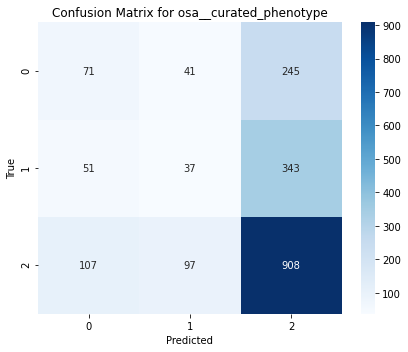

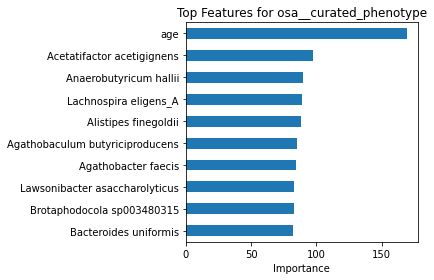


🧬 Target: migraine__curated_phenotype
❌ Skipping migraine__curated_phenotype: classes with <1% samples detected: ['Severe migraine with chronic treatment']

🧬 Target: abdominal_adiposity__curated_phenotype
<bound method IndexOpsMixin.value_counts of RegistrationCode
10K_1000942861    intermediate abdominal adiposity risk
10K_1001201093               normal abdominal adiposity
10K_1002033709    intermediate abdominal adiposity risk
10K_1002254441    intermediate abdominal adiposity risk
10K_1007330152            high abdominal adiposity risk
                                  ...                  
10K_9995623290    intermediate abdominal adiposity risk
10K_9995823183               normal abdominal adiposity
10K_9996884777            high abdominal adiposity risk
10K_9999226141    intermediate abdominal adiposity risk
10K_9999409119            high abdominal adiposity risk
Name: abdominal_adiposity__curated_phenotype, Length: 9299, dtype: category
Categories (3, object): ['normal abdomin

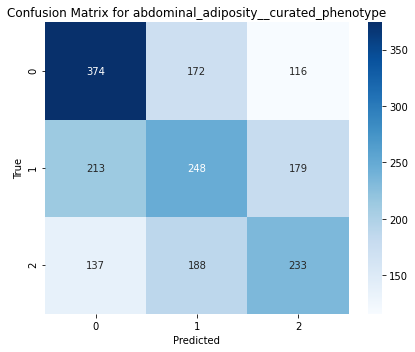

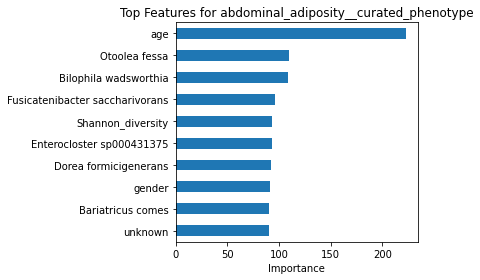


🧬 Target: anxiety__curated_phenotype
❌ Skipping anxiety__curated_phenotype: classes with <1% samples detected: ['Anxiety Level 4', 'Anxiety Level 2', 'Anxiety Level 3']

🧬 Target: diabetes__curated_phenotype
❌ Skipping diabetes__curated_phenotype: classes with <1% samples detected: ['diabetes', 'low confidence diabetes']

🧬 Target: depression__curated_phenotype
<bound method IndexOpsMixin.value_counts of RegistrationCode
10K_1000942861        Depressed
10K_1001201093    Not depressed
10K_1002033709    Not depressed
10K_1002254441    Not depressed
10K_1003113258    Not depressed
                      ...      
10K_9995823183    Not depressed
10K_9996884777    Not depressed
10K_9998420917    Not depressed
10K_9999226141        Depressed
10K_9999409119    Not depressed
Name: depression__curated_phenotype, Length: 10394, dtype: category
Categories (2, object): ['Not depressed' < 'Depressed']>
Not depressed    8077
Depressed         238
Name: depression__curated_phenotype, dtype: int64
Not

/usr/wisdom/python3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


               precision    recall  f1-score   support

    Depressed       0.00      0.00      0.00        59
Not depressed       0.97      1.00      0.99      2020

     accuracy                           0.97      2079
    macro avg       0.49      0.50      0.49      2079
 weighted avg       0.94      0.97      0.96      2079



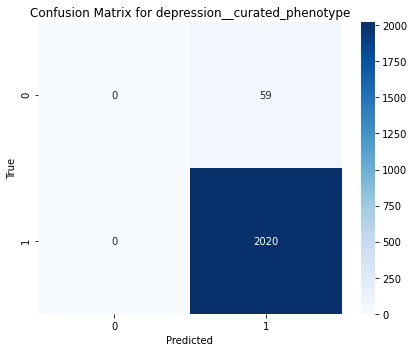

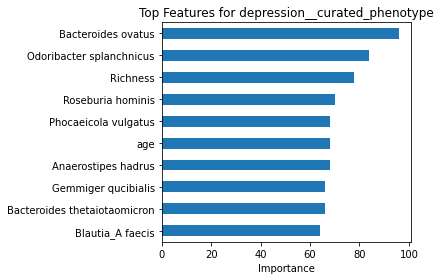


🧬 Target: osteoporosis__curated_phenotype
<bound method IndexOpsMixin.value_counts of RegistrationCode
10K_1000942861    normal BMD
10K_1001201093    normal BMD
10K_1002033709    normal BMD
10K_1002254441    normal BMD
10K_1003113258    normal BMD
                     ...    
10K_9995823183    osteopenia
10K_9996884777    osteopenia
10K_9998420917    normal BMD
10K_9999226141    normal BMD
10K_9999409119    normal BMD
Name: osteoporosis__curated_phenotype, Length: 10102, dtype: category
Categories (3, object): ['normal BMD' < 'osteopenia' < 'osteoporosis']>
normal BMD      6695
osteopenia      1256
osteoporosis     130
Name: osteoporosis__curated_phenotype, dtype: int64
normal BMD      1674
osteopenia       314
osteoporosis      33
Name: osteoporosis__curated_phenotype, dtype: int64
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057072 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185658
[LightG

/usr/wisdom/python3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

  normal BMD       0.83      0.97      0.90      1674
  osteopenia       0.20      0.04      0.06       314
osteoporosis       0.00      0.00      0.00        33

    accuracy                           0.81      2021
   macro avg       0.34      0.34      0.32      2021
weighted avg       0.72      0.81      0.75      2021



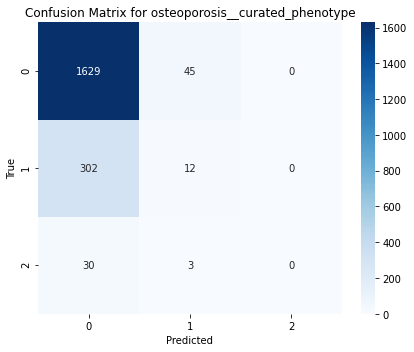

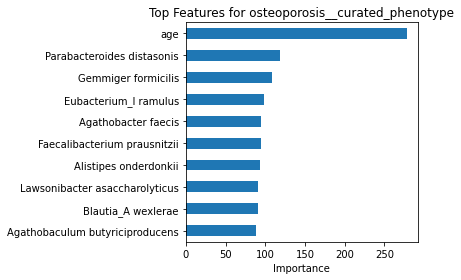


🧬 Target: hypertension__acc_aha_ranges
<bound method IndexOpsMixin.value_counts of RegistrationCode
10K_1001201093      Normal
10K_1002033709      Normal
10K_1002254441      Normal
10K_1003113258     Stage 2
10K_1007330152     Stage 2
                    ...   
10K_9995623290     Stage 1
10K_9995823183    Elevated
10K_9996884777      Normal
10K_9999226141     Stage 1
10K_9999409119     Stage 1
Name: hypertension__acc_aha_ranges, Length: 9295, dtype: category
Categories (4, object): ['Normal' < 'Elevated' < 'Stage 1' < 'Stage 2']>
Normal      3272
Stage 1     2730
Stage 2      741
Elevated     693
Name: hypertension__acc_aha_ranges, dtype: int64
Normal      818
Stage 1     683
Stage 2     185
Elevated    173
Name: hypertension__acc_aha_ranges, dtype: int64
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.042853 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 182781
[LightGBM] [Info] Number of data po

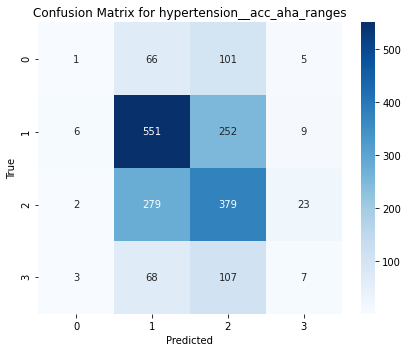

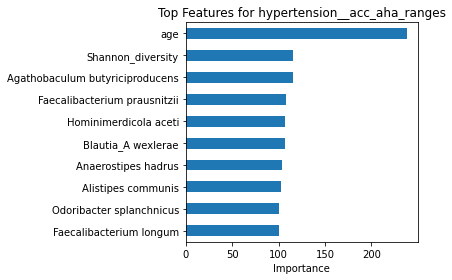


🧬 Target: depression__probable_recurrent_major_depression
<bound method IndexOpsMixin.value_counts of RegistrationCode
10K_1000942861    Not depressed
10K_1001201093    Not depressed
10K_1002033709    Not depressed
10K_1002254441    Not depressed
10K_1003113258    Not depressed
                      ...      
10K_9995823183    Not depressed
10K_9996884777    Not depressed
10K_9998420917    Not depressed
10K_9999226141           Severe
10K_9999409119    Not depressed
Name: depression__probable_recurrent_major_depression, Length: 10394, dtype: category
Categories (3, object): ['Severe' < 'Moderate' < 'Not depressed']>
Not depressed    7647
Severe            470
Moderate          198
Name: depression__probable_recurrent_major_depression, dtype: int64
Not depressed    1912
Severe            118
Moderate           49
Name: depression__probable_recurrent_major_depression, dtype: int64
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055846 seconds.
You

/usr/wisdom/python3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


               precision    recall  f1-score   support

     Moderate       0.00      0.00      0.00        49
Not depressed       0.92      1.00      0.96      1912
       Severe       0.00      0.00      0.00       118

     accuracy                           0.92      2079
    macro avg       0.31      0.33      0.32      2079
 weighted avg       0.85      0.92      0.88      2079



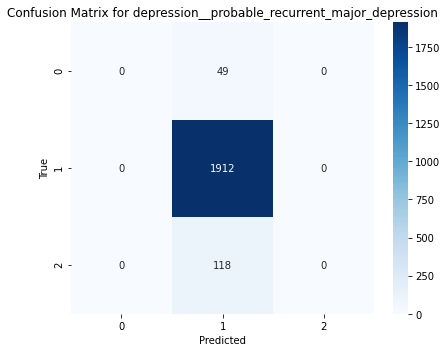

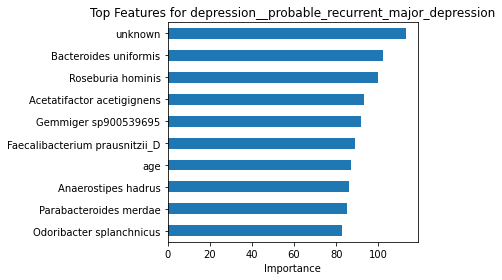


🧬 Target: adhd__curated_phenotype
<bound method IndexOpsMixin.value_counts of RegistrationCode
10K_1000942861         No ADHD
10K_1001201093         No ADHD
10K_1002033709         No ADHD
10K_1002254441         No ADHD
10K_1003113258         No ADHD
                      ...     
10K_9995823183         No ADHD
10K_9996884777         No ADHD
10K_9998420917         No ADHD
10K_9999226141    Treated ADHD
10K_9999409119         No ADHD
Name: adhd__curated_phenotype, Length: 10066, dtype: category
Categories (3, object): ['No ADHD' < 'Untreated ADHD' < 'Treated ADHD']>
No ADHD           7481
Untreated ADHD     341
Treated ADHD       230
Name: adhd__curated_phenotype, dtype: int64
No ADHD           1871
Untreated ADHD      85
Treated ADHD        58
Name: adhd__curated_phenotype, dtype: int64
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.054306 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185106
[Lig

/usr/wisdom/python3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                precision    recall  f1-score   support

       No ADHD       0.93      1.00      0.96      1871
  Treated ADHD       0.00      0.00      0.00        58
Untreated ADHD       0.00      0.00      0.00        85

      accuracy                           0.93      2014
     macro avg       0.31      0.33      0.32      2014
  weighted avg       0.86      0.93      0.89      2014



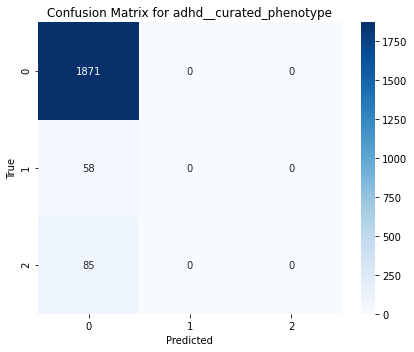

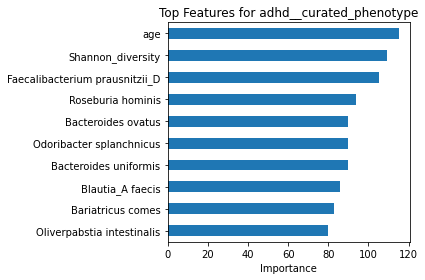


🧬 Target: ischemic_heart_disease__curated_phenotype
❌ Skipping ischemic_heart_disease__curated_phenotype: classes with <1% samples detected: ['Ischemic Heart Disease']

🧬 Target: bmi__curated_phenotype
❌ Skipping bmi__curated_phenotype: classes with <1% samples detected: ['Underweight', 'Severe obesity']


In [15]:
# 📘 Multi-Class Classification with LightGBM
#     Using Separate DataFrames: phenotypes_df and gut_microbes_df

# Ensure matching indices
gut_bacteria_df = gut_bacteria_df.sort_index()
phenotypes_df = phenotypes_df.sort_index()

# Optional sanity check
common_indices = gut_bacteria_df.index.intersection(phenotypes_df.index)
print(f"✅ {len(common_indices)} samples found in both datasets.")

# --- 2. Define Helper Function for Pipeline ---
def make_pipeline(num_classes):
    return Pipeline([
        ('var_thresh', VarianceThreshold(threshold=0.01)),
        ('scaler', StandardScaler()),  # Optional for LightGBM
        ('model', LGBMClassifier(
            objective='multiclass',
            num_class=num_classes,
            n_estimators=200,
            random_state=1,
            n_jobs=8,
            class_weight='balanced'
        ))
    ])

# --- 3. Loop Through Phenotypes ---
for pheno in phenotypes_df.columns:
    print(f"\n🧬 Target: {pheno}")

    # Drop rows with NaNs in either the features or this specific phenotype
    df_sub = pd.concat([gut_bacteria_df, phenotypes_df[pheno]], axis=1)
    df_sub = df_sub.dropna()

    # Skip if any class has <5% of the samples
    class_counts = df_sub[pheno].value_counts(normalize=True)
    too_small = class_counts[class_counts < 0.01]

    if not too_small.empty:
        print(f"❌ Skipping {pheno}: classes with <1% samples detected: {too_small.index.tolist()}")
        continue


    X = df_sub[gut_bacteria_df.columns]
    y = df_sub[pheno]

    print(y.value_counts)
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )
    print(y_train.value_counts())
    print(y_test.value_counts())

    # Create and fit pipeline
    num_classes = y.nunique()
    pipe = make_pipeline(num_classes)
    pipe.fit(X_train, y_train)

    # Predict and evaluate
    y_pred = pipe.predict(X_test)
    print(classification_report(y_test, y_pred))

    # --- Confusion Matrix ---
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix for {pheno}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

    # --- Feature Importances ---
    model = pipe.named_steps['model']
    selected_features = X_train.columns[pipe.named_steps['var_thresh'].get_support()]
    importances = pd.Series(model.feature_importances_, index=selected_features)
    
    top_importances = importances.sort_values(ascending=False).head(10)
    top_importances.plot(kind='barh')
    plt.title(f"Top Features for {pheno}")
    plt.xlabel("Importance")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()


### Load Medical Conditions

In [10]:
loader = MedicalConditionLoader(gen_cache=False)
medcon_df = loader.get_data().df
medcon_meta = loader.get_data().df_metadata
medcon_df.head()

Start
RegistrationCode Date                medical_condition       
10K_8843698074   2018-01-01 00:00:00 GB20.0              True
10K_3774586502   1960-01-01 00:00:00 CA23                True
                 2018-01-01 00:00:00 GA90                True
10K_1800033930   2005-01-01 00:00:00 4A60.0              True
10K_7833168704   2015-01-01 00:00:00 DD91.0              True

In [15]:
len(list(medcon_meta["name"].unique()))

1035

In [20]:
medcon_reset = medcon_df.reset_index()
len(medcon_reset["medical_condition"].unique())

478

### Load Blood Tests

In [21]:
blood_df = pd.read_pickle(path + "blood_df.pkl")
blood_df

,bt__eosinophils_abs,bt__monocytes_abs,bt__calcium,bt__creatinine,bt__albumin,bt__mchc,bt__lymphocytes_abs,bt__ferritin,bt__lymphocytes_%,bt__neutrophils_%,bt__basophils_%,bt__monocytes_%,bt__eosinophils_%,bt__alkaline_phosphatase,bt__rbc,bt__urea,bt__hemoglobin,bt__vitamin_b12,bt__alt_gpt,bt__platelets,bt__neutrophils_abs,bt__mean_platelet_volume,bt__ldl_cholesterol,bt__wbc,bt__protein_total,bt__rdw,bt__ast_got,bt__hct,bt__mch,bt__potassium,bt__non_hdl_cholesterol,bt__total_cholesterol,bt__mcv,bt__basophils_abs,bt__glucose,bt__triglycerides,bt__bilirubin_total,bt__tsh,bt__sodium,bt__hdl_cholesterol,weight,unit_id,meal_type,score
RegistrationCode,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
10K_1000942861,0.18,0.64,NaN,1.04,4.2,33.0,2.92,86.0,45.30,40.30,1.70,9.90,2.80,70.0,5.31,32.0,15.20,NaN,23.0,230.0,2.59,11.30,171.2,6.40,7.0,12.9,NaN,46.1,28.6,4.1,201.0,255.0,87.0,0.11,109.0,148.0,1.1,2.66,138.0,54.0,6.0,3,NaN,NaN
10K_1002033709,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,92.0,NaN,NaN,NaN,NaN,NaN,60.0,31,NaN,NaN
10K_1002254441,0.09,0.51,9.8,0.72,NaN,33.6,1.54,NaN,29.70,58.20,0.60,9.80,1.70,44.0,4.91,33.0,14.60,NaN,18.0,221.0,3.02,10.20,184.4,5.20,NaN,12.3,26.0,43.5,29.7,4.4,201.0,261.0,89.0,0.03,100.0,84.0,NaN,NaN,140.0,60.0,152.0,48,NaN,NaN
10K_1006172497,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,85.0,NaN,NaN,NaN,NaN,NaN,30.0,21,NaN,NaN
10K_1007400622,0.08,0.52,NaN,0.53,NaN,34.4,1.92,106.0,39.80,47.10,0.60,10.80,1.70,NaN,4.36,40.0,13.50,763.0,NaN,200.0,NaN,12.30,121.9,4.80,NaN,12.4,NaN,39.3,31.0,NaN,140.0,221.0,90.0,0.03,85.0,89.0,1.1,1.82,NaN,81.0,103.0,21,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10K_3856217837,0.03,0.43,NaN,NaN,NaN,34.0,1.44,NaN,25.91,65.10,0.83,7.66,0.51,NaN,4.81,NaN,15.18,NaN,NaN,270.8,3.61,10.62,NaN,5.55,NaN,12.7,NaN,44.7,31.6,NaN,NaN,NaN,93.0,0.05,NaN,NaN,NaN,NaN,NaN,NaN,76.0,nan,NaN,NaN
10K_8691163069,0.11,0.51,NaN,NaN,NaN,35.1,1.67,NaN,36.05,50.33,0.20,11.06,2.35,NaN,4.95,NaN,14.97,NaN,NaN,277.2,2.33,7.99,NaN,4.62,NaN,13.6,NaN,42.7,30.2,NaN,NaN,NaN,86.2,0.01,NaN,NaN,NaN,NaN,NaN,NaN,50.0,47,NaN,NaN
10K_5202285462,0.23,0.58,NaN,NaN,NaN,33.3,1.94,NaN,35.53,49.39,0.21,10.58,4.29,NaN,5.21,NaN,15.53,NaN,NaN,248.0,2.69,8.20,NaN,5.45,NaN,14.0,NaN,46.6,29.8,NaN,NaN,NaN,89.5,0.01,NaN,NaN,NaN,NaN,NaN,NaN,143.0,31,NaN,NaN


In [ ]:
# 📘 Multi-Class Classification with LightGBM
#     Using Separate DataFrames: phenotypes_df and gut_microbes_df

# Ensure matching indices
gut_bacteria_df = gut_bacteria_df.sort_index()
phenotypes_df = phenotypes_df.sort_index()

# Optional sanity check
common_indices = gut_bacteria_df.index.intersection(phenotypes_df.index)
print(f"✅ {len(common_indices)} samples found in both datasets.")

# --- 2. Define Helper Function for Pipeline ---
def make_pipeline(num_classes):
    return Pipeline([
        ('var_thresh', VarianceThreshold(threshold=0.01)),
        ('scaler', StandardScaler()),  # Optional for LightGBM
        ('model', LGBMClassifier(
            objective='multiclass',
            num_class=num_classes,
            n_estimators=200,
            random_state=1,
            n_jobs=8,
            class_weight='balanced'
        ))
    ])

# --- 3. Loop Through Phenotypes ---
for pheno in phenotypes_df.columns:
    print(f"\n🧬 Target: {pheno}")

    # Drop rows with NaNs in either the features or this specific phenotype
    df_sub = pd.concat([gut_bacteria_df, phenotypes_df[pheno]], axis=1)
    df_sub = df_sub.dropna()

    # Skip if any class has <5% of the samples
    class_counts = df_sub[pheno].value_counts(normalize=True)
    too_small = class_counts[class_counts < 0.01]

    if not too_small.empty:
        print(f"❌ Skipping {pheno}: classes with <1% samples detected: {too_small.index.tolist()}")
        continue


    X = df_sub[gut_bacteria_df.columns]
    y = df_sub[pheno]

    print(y.value_counts)
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )
    print(y_train.value_counts())
    print(y_test.value_counts())

    # Create and fit pipeline
    num_classes = y.nunique()
    pipe = make_pipeline(num_classes)
    pipe.fit(X_train, y_train)

    # Predict and evaluate
    y_pred = pipe.predict(X_test)
    print(classification_report(y_test, y_pred))

    # --- Confusion Matrix ---
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix for {pheno}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

    # --- Feature Importances ---
    model = pipe.named_steps['model']
    selected_features = X_train.columns[pipe.named_steps['var_thresh'].get_support()]
    importances = pd.Series(model.feature_importances_, index=selected_features)
    
    top_importances = importances.sort_values(ascending=False).head(10)
    top_importances.plot(kind='barh')
    plt.title(f"Top Features for {pheno}")
    plt.xlabel("Importance")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
